# Context utilization with Ragas

This notebook shows you how to validate changes on your RAG application against context utilization.  
We rely on Ragas to evaluate that metric, to then visualize our iterative experiments in Literal AI.

First, we create a dataset from an example RAG application. Second, we evaluate the impact of a retrieval parameter change (order of contexts) on context utilization: 
- [Run a RAG application](#run-rag-app)
- [Create a Dataset](#create-dataset)
- [Experiment A &ndash; # contexts = 2](#experiment-a)
    - Evaluate with Ragas
    - Persist experiment to Literal
- [Experiment B &ndash; # contexts = 1](#experiment-b)
    - Evaluate with Ragas
    - Persist experiment to Literal


<a id="run-rag-app"></a>
## Run a RAG application

### Create a Chroma vector database

In [1]:
import chromadb

chroma_client = chromadb.Client()

collection = chroma_client.get_or_create_collection("Biography")
collection.add(
    documents=["My name is John.", "My job is coding.", "My dog's name is Fido. Fido is an expert fetcher."],
    ids=["id1", "id2", "id3"]
)

### Import the Literal SDK

In [2]:
import os

from openai import OpenAI
from dotenv import load_dotenv
from literalai import LiteralClient

os.environ.clear()
load_dotenv()

openai_client = OpenAI()

literalai_client = LiteralClient()
literalai_client.instrument_openai()

### Create a prompt

In [3]:
PROMPT_NAME = "RAG prompt"
template_messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant that always answers questions. Keep it short, and if available prefer responding with code."
    },
    {
        "role": "user",
        "content": "Answer the question based on the context below.\nContext:\n{{#context}}\n{{.}}\n{{/context}}\nQuestion:\n{{question}}\nAnswer:"
    }
]

prompt = literalai_client.api.get_or_create_prompt(name=PROMPT_NAME, template_messages=template_messages)

### Ask questions to RAG application

In [4]:
@literalai_client.step(type="run", name="RAG")
def rag(user_query: str):
    with literalai_client.step(type="retrieval", name="Retrieve") as step:
        step.input = { "question": user_query }
        results = collection.query(query_texts=[user_query], n_results=2)
        step.output = results

    messages = prompt.format_messages(context=results["documents"][0], question=user_query)
    
    completion = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
    )

    return completion.choices[0].message.content
        
def main():
    questions = [ "What's my name?", "What's my job?" ]
    for idx, question in enumerate(questions):
        with literalai_client.thread(name=f"Question {idx+1}") as thread:
            literalai_client.message(content=question, type="user_message", name="User")
            answer = rag(question)
            literalai_client.message(content=answer, type="assistant_message", name="My Assistant")

main()

# Network requests by the SDK are performed asynchronously.
# Invoke flush() to guarantee the completion of all requests prior to the process termination.
# WARNING: If you run a continuous server, you should not use this method.
literalai_client.flush()

<a id="create-dataset"></a>
## Create a Dataset

In [5]:
DATASET_NAME = f"Biography Evaluation Dataset"

dataset = literalai_client.api.get_dataset(name=DATASET_NAME)

In [6]:
if not dataset:
    dataset = literalai_client.api.create_dataset(name=DATASET_NAME)
    
    threads = literalai_client.api.get_threads(first=2).data
    
    rag_steps = []
    for thread in threads:
        rag_steps.extend([step for step in thread.steps if step.name == "RAG"])
    
    for step in rag_steps:
        dataset.add_step(step.id)

<a id="experiment-a"></a>
## Experiment A - # contexts = 2

### Evaluate with Ragas

#### Prepare Ragas data samples

In [7]:
import json

from literalai import DatasetItem
from typing import List

items = dataset.items

# Get the retrieved contexts for each question.
contexts = []
for item in items:
    retrieve_step = next(step for step in item.intermediary_steps if step["name"] == "Retrieve")
    contexts.append(retrieve_step["output"]["documents"][0])

# Data samples, in the format expected by Ragas. No ground truth needed since we will evaluate context utilization. 
# Context Utilization cannot be imported from Ragas anymore, so we put the answers directly as ground truths and call the
# context_precision metric instead (strictly equivalent in that case).
data_samples = {
    'question': [item.input["user_query"] for item in items],
    'answer': [""] * len(items),
    'contexts': contexts,
    'ground_truth': [item.expected_output["content"] for item in items]
}

#### Run the evaluation

We will evaluate context utilization which checks how much of the retrieved contexts is used to reach the answer and how well chunks are ordered.

The more unneeded details in the contexts, the less used (between 0 and 1, 0 being least used).

In [8]:
from datasets import Dataset

from ragas import evaluate
from ragas.metrics import context_precision

# Ragas has this issue where it now requires to install LlamaIndex, you might face: "No module named 'llama_index'"
# See https://github.com/explodinggradients/ragas/issues/1655
results = evaluate(Dataset.from_dict(data_samples), metrics=[context_precision]).to_pandas()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

### Persist experiment to Literal AI

In [9]:
import pandas as pd

# Create a prompt variant ID from your prompt to track the variants
# you experiment on.
prompt_variant_id = literalai_client.api.create_prompt_variant(
    name=prompt.name, 
    settings=prompt.settings, 
    template_messages=prompt.template_messages, 
    tools=prompt.tools)

experiment = dataset.create_experiment(
    name="Biography - Experiment A",
    prompt_variant_id=prompt_variant_id,
    params=[{ "type": "Context Utilization", "top_k": 2 }],
)

# Log each experiment result.
for index, row in results.iterrows():
    utilization_score = row[context_precision.name]
    if pd.isna(utilization_score):
        utilization_score = 0

    scores = [{ 
        "name": "Context Utilization",
        "type": "AI",
        "value": utilization_score
    }]

    experiment_item = {
        "datasetItemId": items[index].id,
        "scores": scores,
        "input": { "question": row["user_input"] },
        "output": { "contexts": row["retrieved_contexts"] }
    }
    
    experiment.log(experiment_item)

<a id="experiment-b"></a>
## Experiment B - # contexts = 2 - in reverse order

### Evaluate with Ragas

We evaluate with the first context only to see how context utilization gets impacted.

In [10]:
data_samples["contexts"] = [x[::-1] for x in contexts]

results = evaluate(Dataset.from_dict(data_samples), metrics=[context_precision]).to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

### Persist experiment to Literal AI

In [11]:
experiment = dataset.create_experiment(
    name="Biography - Experiment B",
    prompt_variant_id=prompt_variant_id,
    params=[{ "type": "Context Utilization", "top_k": 2, "revers": True }]
)

# Log each experiment result.
for index, row in results.iterrows():
    utilization_score = row[context_precision.name]
    if pd.isna(utilization_score):
        utilization_score = 0

    scores = [{ 
        "name": "Context Utilization",
        "type": "AI",
        "value": utilization_score
    }]

    experiment_item = {
        "datasetItemId": items[index].id,
        "scores": scores,
        "input": { "question": row["user_input"] },
        "output": { "contexts": row["retrieved_contexts"] }
    }
    
    experiment.log(experiment_item)

## Visualize from Literal AI Experiments !

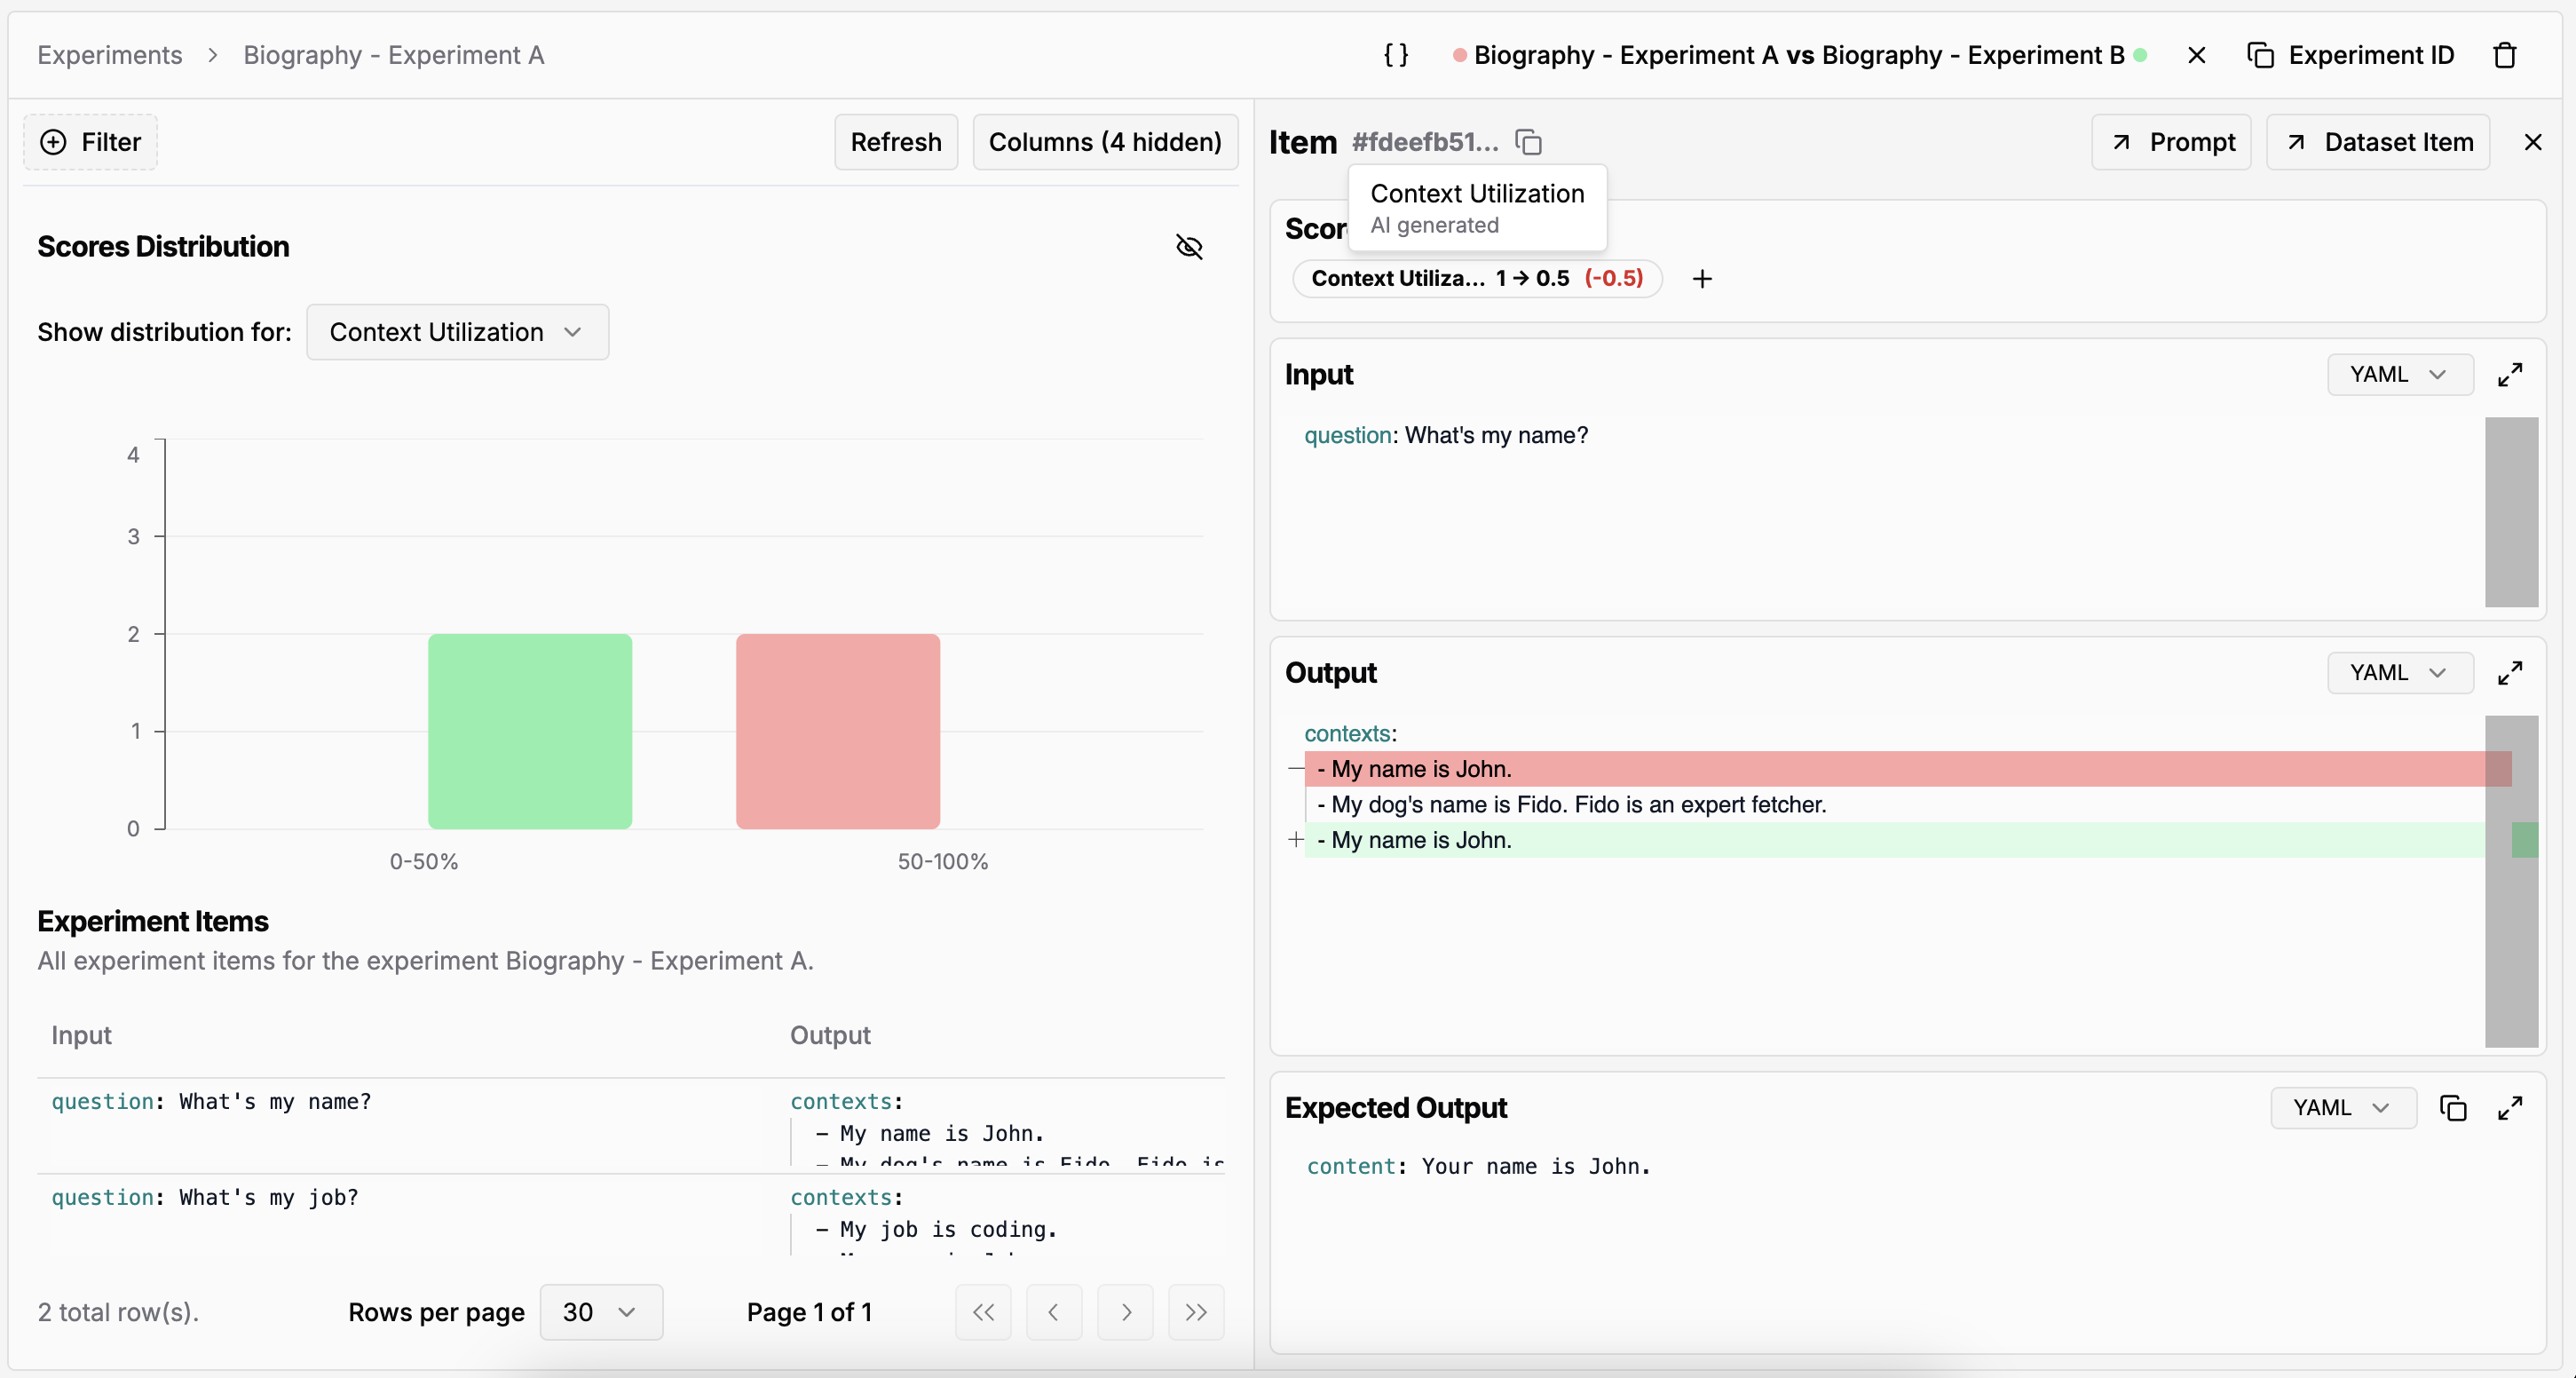